In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Selecting HIP 104214 from the list of perfect targets (p14) and seeing what I can find. Fun Friday afternoon project.

In [7]:
path = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/'

In [8]:
iuespecs = glob.glob('{}iue/*vo.fits'.format(path))
iuespecs

['/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/iue/lwr05272mxlo_vo.fits',
 '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/iue/lwr05273mxlo_vo.fits',
 '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/iue/swp06087mxlo_vo.fits',
 '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-104214/iue/swp06088mxlo_vo.fits']

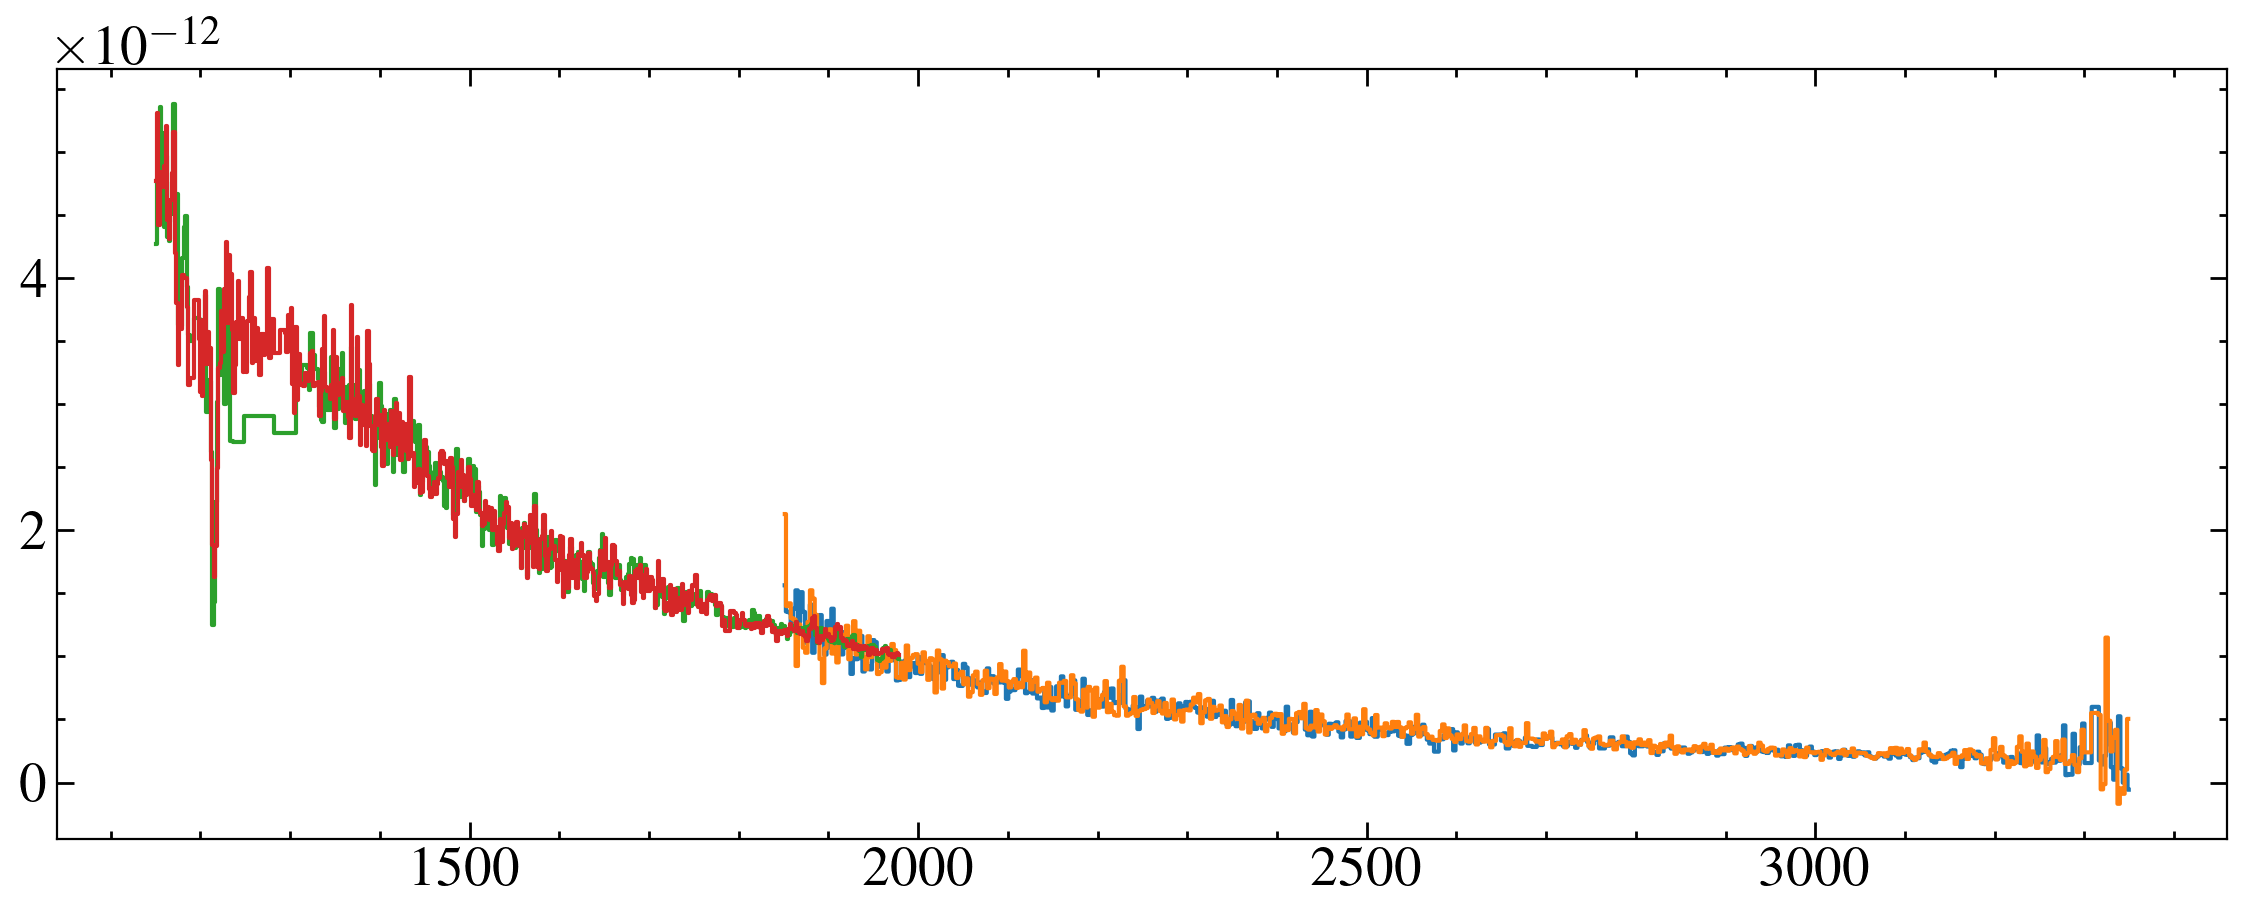

In [9]:
fig, ax = plt.subplots()

for spec in iuespecs:
    data = fits.getdata(spec, 1)[0]
    w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
    ax.step(w[dq==0],f[dq==0], where='mid')
    # ax.step(w,e, where='mid')
    

Seems like it's going the wrong way?Ah- it's the wrong star! MAST box too big. Try agian with a different one!  HIP 108870 = eps ind has loads of IUE data!

In [14]:
path = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/'

In [42]:
iuespecs = glob.glob('{}iue/*vo.fits'.format(path))
# iuespecs

(1e-15, 6.56231097207592e-10)

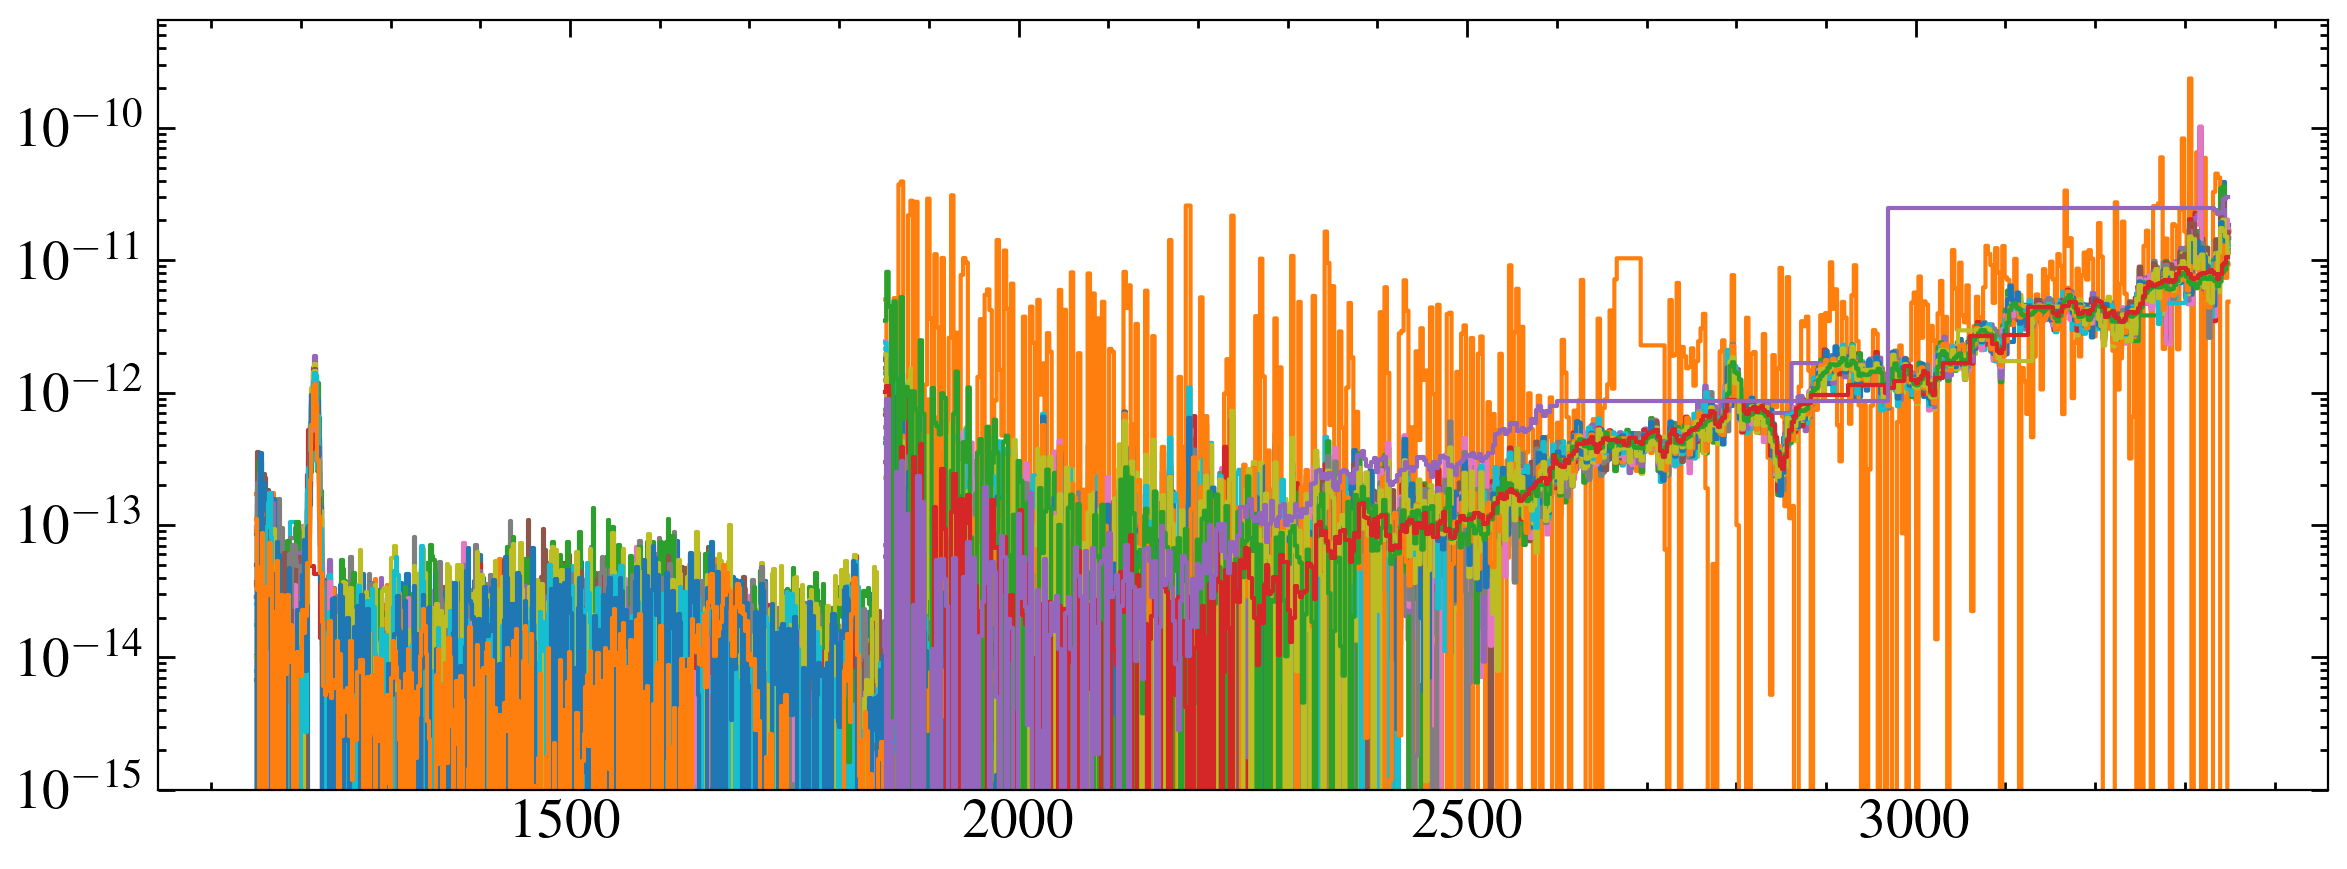

In [47]:
fig, ax = plt.subplots()

for spec in iuespecs:
    data = fits.getdata(spec, 1)[0]
    w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
    ax.step(w[dq==0],f[dq==0], where='mid')
    
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(1e-15)


One of these is not like the others? Fixed, MAST does not clear the download basket once you've finished with it. Good to know. Some potenitally interesting flux calibration fun there. lwr14068mxlo_vo.fits is a wavecal? Fixed. Something up with lwr10686mxlo_vo.fits.

In [50]:
stisspecs = glob.glob('{}hst/*x1d.fits'.format(path))
stisspecs

['/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/hst/ob4501010_x1d.fits']

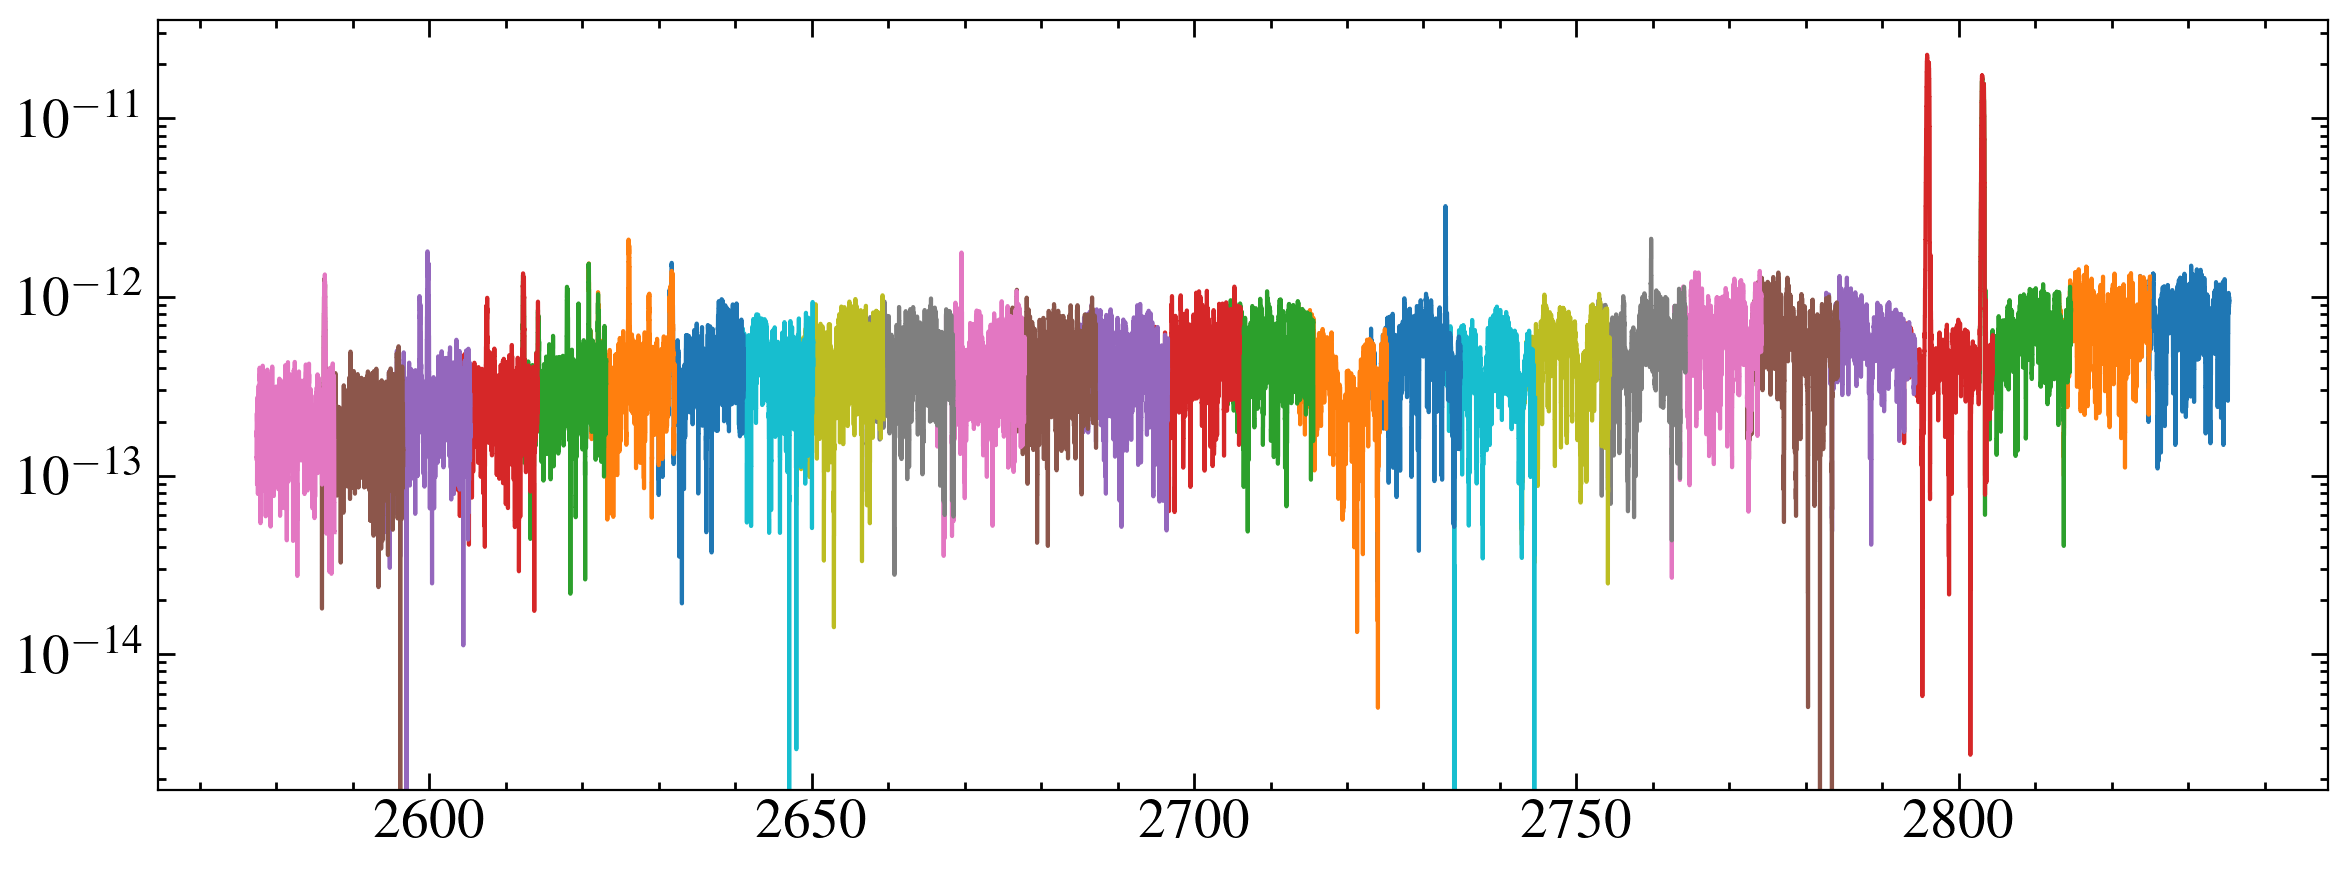

In [54]:
fig, ax = plt.subplots()

for spec in stisspecs:
    alldata = fits.getdata(spec, 1)
    for data in alldata:
        w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
        ax.step(w[dq==0],f[dq==0], where='mid')
ax.set_yscale('log')


Need to writre a script that extracts GHRS files. For now:

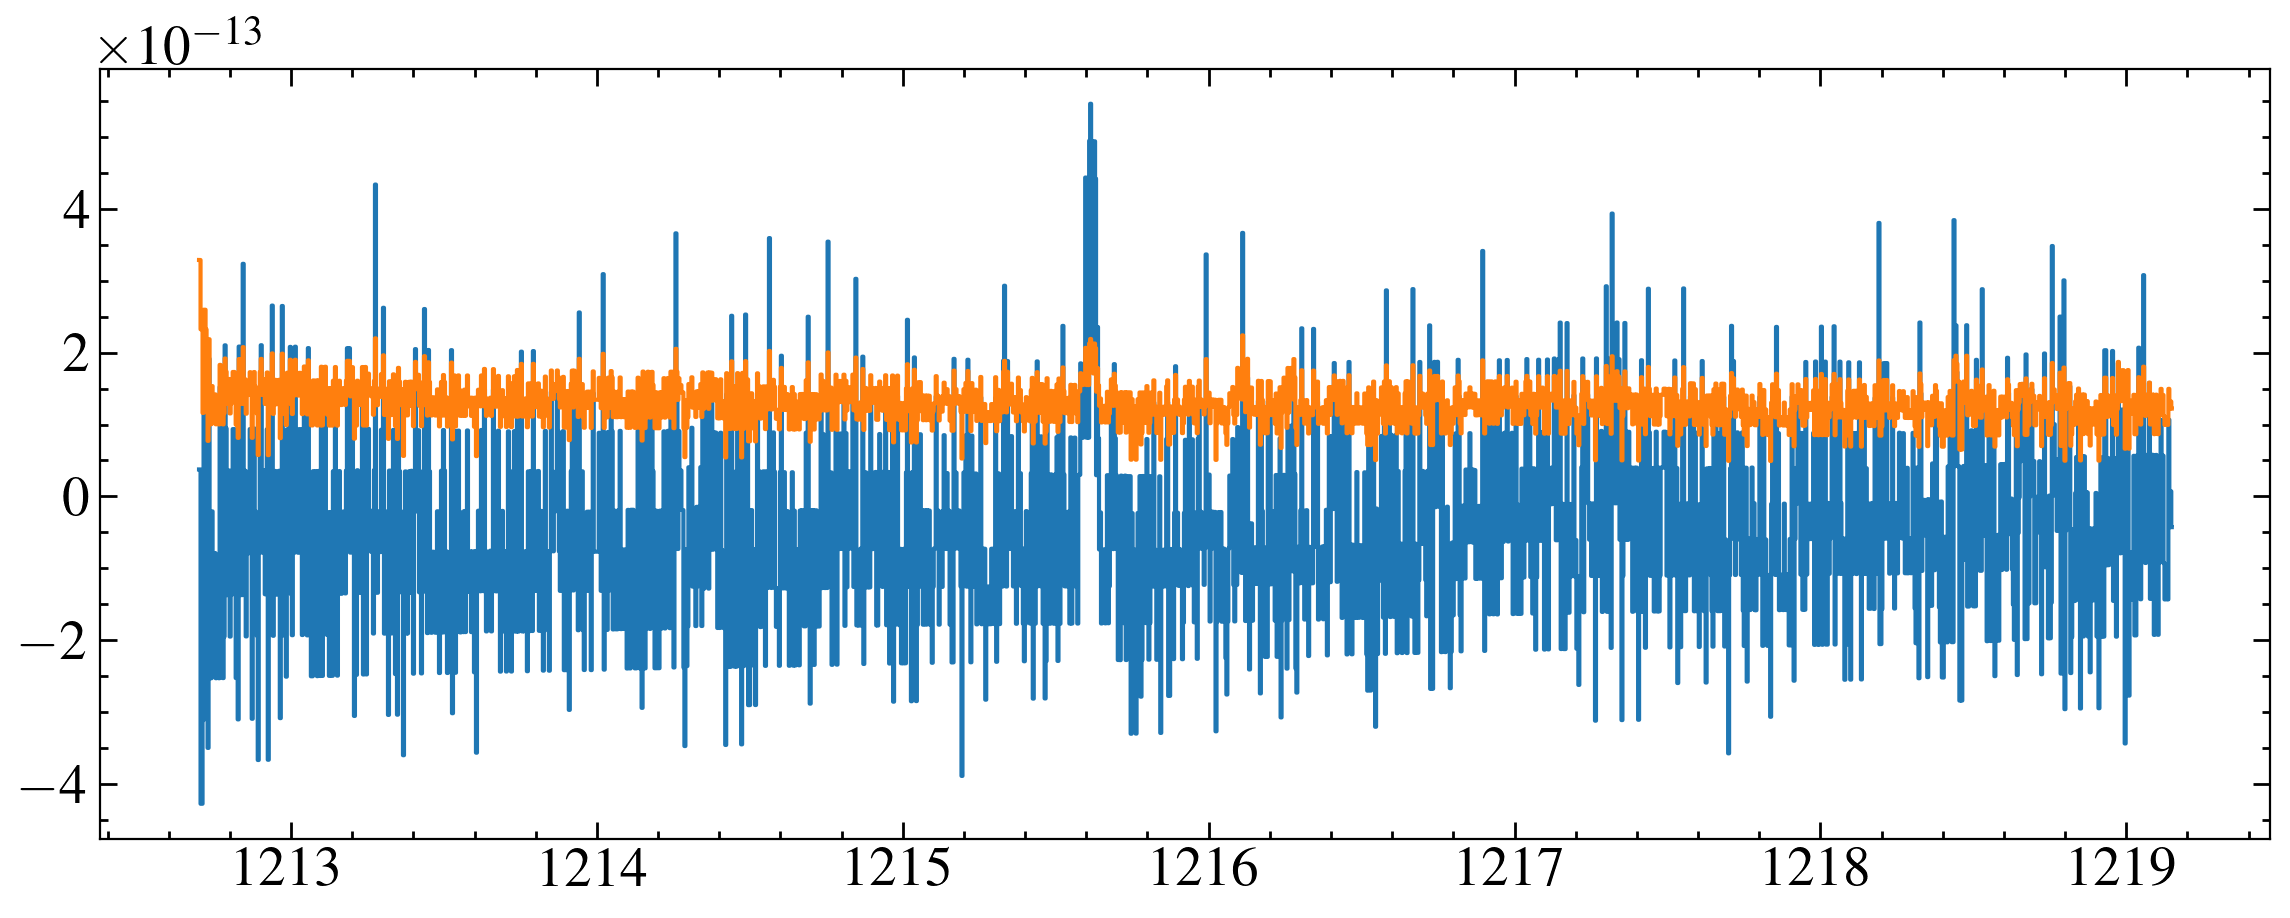

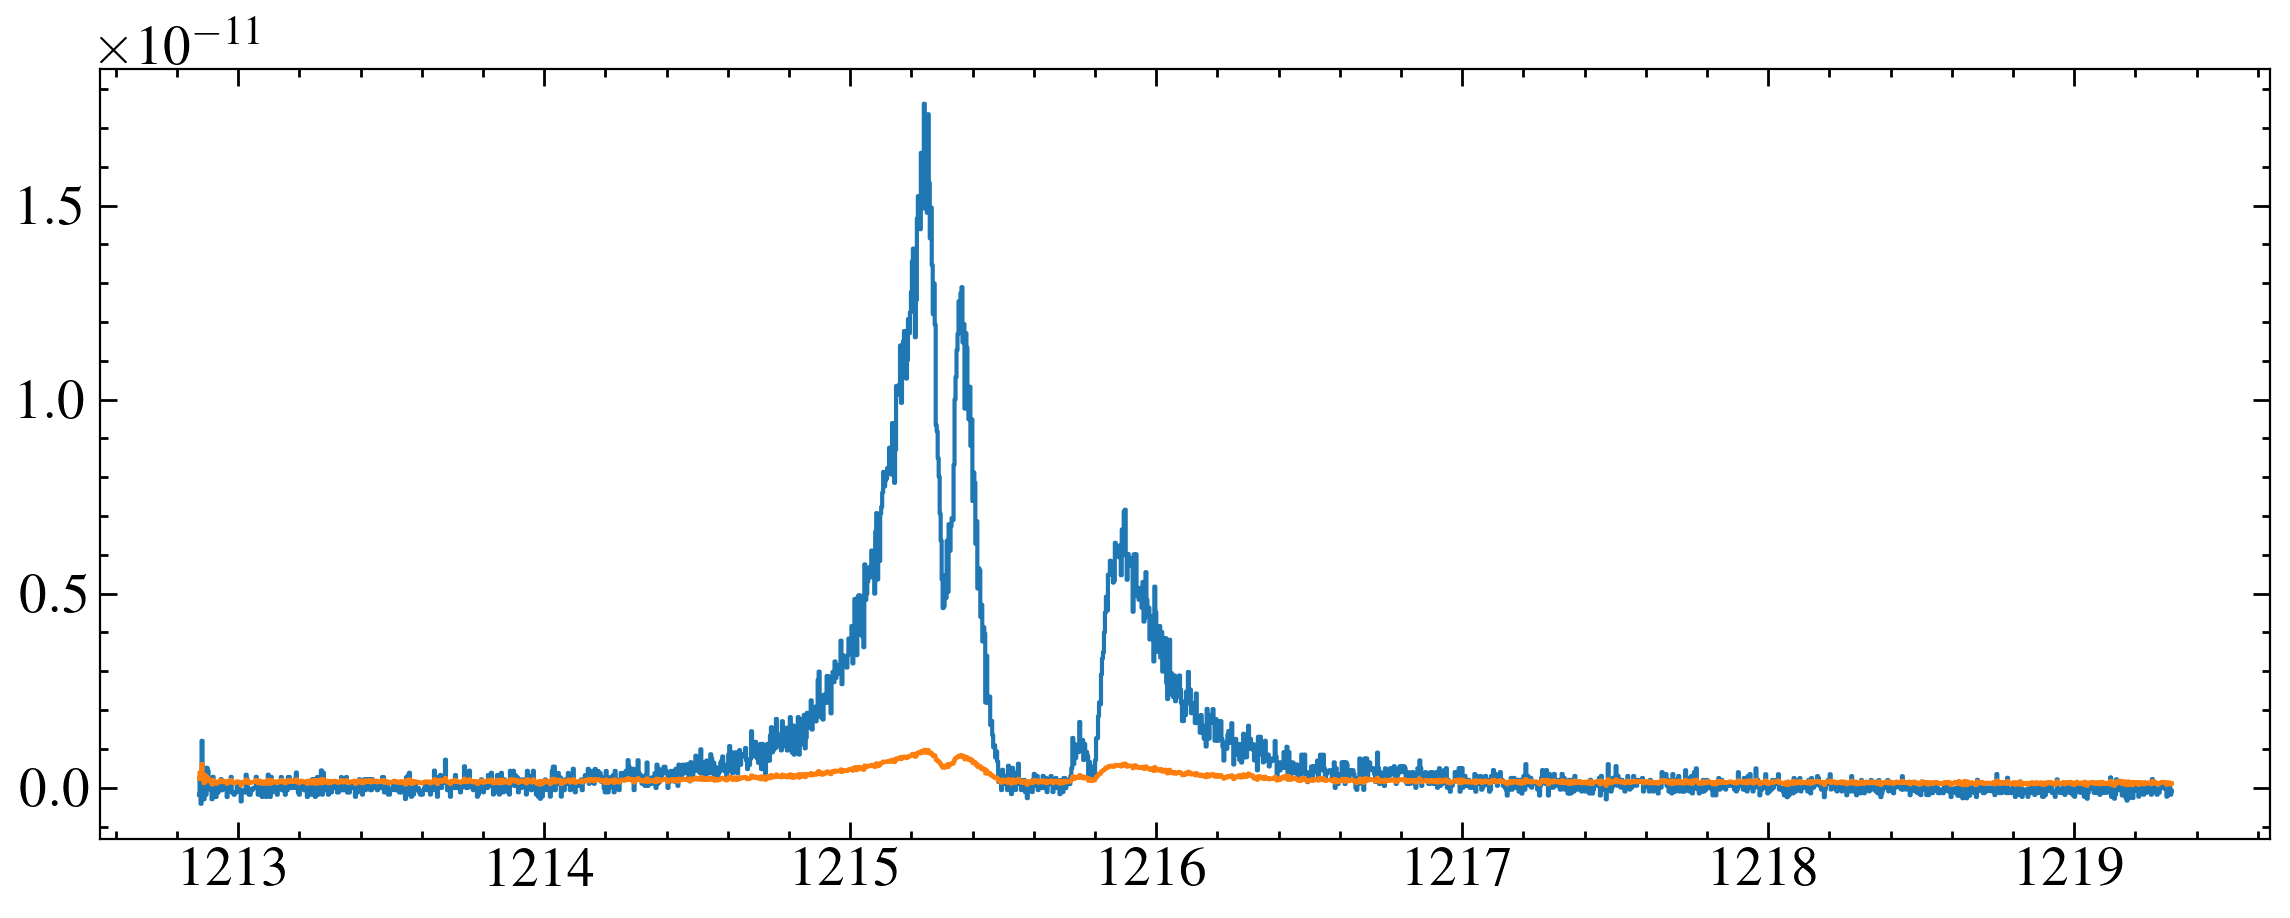

In [64]:

ghrsroots = ['z2h00108t', 'z2h00308m']
for root in ghrsroots:
    fig, ax = plt.subplots()

    w = fits.getdata('{}hst/{}_c0f.fits'.format(path, root), 0)
    f = fits.getdata('{}hst/{}_c1f.fits'.format(path, root), 0)
    e = fits.getdata('{}hst/{}_c2f.fits'.format(path, root), 0)

    ax.step(w, f, where='mid')
    ax.step(w, e, where='mid')

    plt.show()
        
        

Nicely resolved Lya line, wonder what happned to the other ob? Looks like a failed extraction. No, failed observation! Think that's it for the UV. Next steps- X-ray, and filter/coadd uv data.